In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

##### Loading extracted features from audiofiles

In [2]:
df = pd.read_csv('./data_c_s/features.csv')
mid_feature_names = df.columns.values[0:-1]
data = df.to_numpy()
features = data[:, 0:-1]
labels = data[:, -1]
print(mid_feature_names)
#print(labels)

['zcr_mean' 'energy_mean' 'energy_entropy_mean' 'spectral_centroid_mean'
 'spectral_spread_mean' 'spectral_entropy_mean' 'spectral_flux_mean'
 'spectral_rolloff_mean' 'mfcc_1_mean' 'mfcc_2_mean' 'mfcc_3_mean'
 'mfcc_4_mean' 'mfcc_5_mean' 'mfcc_6_mean' 'mfcc_7_mean' 'mfcc_8_mean'
 'mfcc_9_mean' 'mfcc_10_mean' 'mfcc_11_mean' 'mfcc_12_mean' 'mfcc_13_mean'
 'chroma_1_mean' 'chroma_2_mean' 'chroma_3_mean' 'chroma_4_mean'
 'chroma_5_mean' 'chroma_6_mean' 'chroma_7_mean' 'chroma_8_mean'
 'chroma_9_mean' 'chroma_10_mean' 'chroma_11_mean' 'chroma_12_mean'
 'chroma_std_mean' 'delta zcr_mean' 'delta energy_mean'
 'delta energy_entropy_mean' 'delta spectral_centroid_mean'
 'delta spectral_spread_mean' 'delta spectral_entropy_mean'
 'delta spectral_flux_mean' 'delta spectral_rolloff_mean'
 'delta mfcc_1_mean' 'delta mfcc_2_mean' 'delta mfcc_3_mean'
 'delta mfcc_4_mean' 'delta mfcc_5_mean' 'delta mfcc_6_mean'
 'delta mfcc_7_mean' 'delta mfcc_8_mean' 'delta mfcc_9_mean'
 'delta mfcc_10_mean' 'delta m

#### Preprocessing Data - Normalization

In [3]:
data_scaled = preprocessing.StandardScaler().fit_transform(features)

##### Analyzing Feature Space

With the 'ind' list one can have a look the different features and how good they seem to be seperated.
In this case the two features energy and delta_energy have been choosen. It seems to be that sneezing produces a constant energy level, while coughing does not.

     energy_mean  delta energy_std  align
0       0.489009          2.251897  Cough
1      -0.266247          0.111119  Cough
2      -0.321451         -0.194486  Cough
3      -0.687469         -0.695109  Cough
4      -0.549311         -0.447905  Cough
..           ...               ...    ...
154    -0.538586         -0.593244  Sneez
155    -0.541626         -0.529285  Sneez
156    -0.654421         -0.639445  Sneez
157    -0.354810         -0.411984  Sneez
158    -0.369800         -0.618689  Sneez

[159 rows x 3 columns]


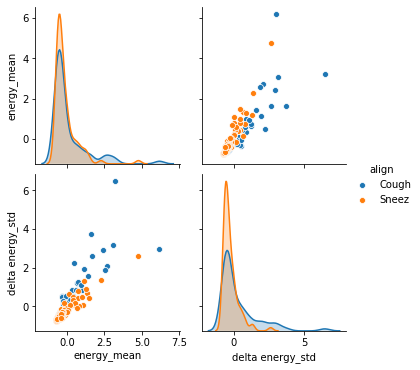

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#ind = [1,68]
#ind = [1,35]
ind = [1,103]
#ind = [69,103]
feature_names = mid_feature_names[ind]
Cough_df_red = pd.DataFrame(data_scaled[:,ind], columns = feature_names )
Cough_df_red["align"] = pd.Series(labels).apply(lambda x: "Sneez" if x==1 else "Cough")
print(Cough_df_red)
g = sns.pairplot(Cough_df_red, hue="align")
plt.show()




### PCA to check how much redundant information is stored in the features.

By having a look at the explained variance ratio one can see that the reduction from 136 to 20 features is possible.  
It seems that there is a huge amount of redundant information in the whole feature space. But any way the PCA is used here to shrink the feature space to dimension 2. But by having a look at the follwing plot one can see that they are not really good seperable. So in the end for our case study to analyse the different behaviours of the traing parameters at SVM we use the to features energy_mean and delta energy_std

Explained variability
[ 39.730733    48.0619664   53.58854538  58.409035    61.83676238
  65.15062956  67.98757291  70.67618922  73.00867306  75.13107974
  77.20252321  79.04977602  80.55287663  82.00146826  83.4159069
  84.65834179  85.82904159  86.97871177  87.97612385  88.93146177
  89.77898898  90.51751016  91.18462963  91.84364881  92.44302184
  93.01893313  93.56879985  94.06656421  94.49592955  94.91061164
  95.28607775  95.61889946  95.94095358  96.22878075  96.50741217
  96.77034615  96.99755744  97.21681304  97.43081864  97.6309083
  97.80743441  97.97910921  98.12501791  98.2582905   98.38545665
  98.49932805  98.60867821  98.71216593  98.8004981   98.884331
  98.96014191  99.02970431  99.09621188  99.15709374  99.21048006
  99.26354669  99.31003741  99.35419557  99.39717995  99.43964817
  99.47635617  99.5125078   99.54660621  99.57790139  99.60684784
  99.63236703  99.65667165  99.67968581  99.70090851  99.7199474
  99.73834716  99.7557548   99.77170871  99.78713374  99.80

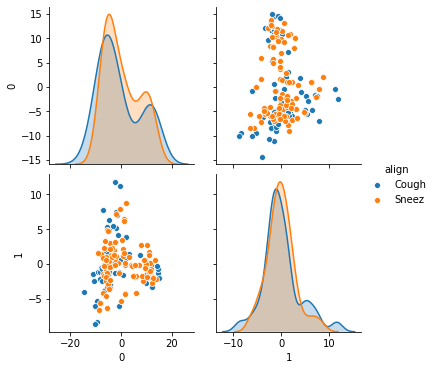

In [21]:
from sklearn import decomposition
#PCA decomposition to eliminate the irrelevant features
print("Explained variability")
pca = decomposition.PCA(whiten=False).fit(data_scaled) 
print(100*pca.explained_variance_ratio_.cumsum())

data_reduced = decomposition.PCA(n_components=2,whiten=False).fit_transform(data_scaled) 

Cough_df_pca = pd.DataFrame(data_reduced)
Cough_df_pca["align"] = pd.Series(labels).apply(lambda x: "Sneez" if x==1 else "Cough")
print(Cough_df_pca)
g = sns.pairplot(Cough_df_pca, hue="align")
plt.show()


#### Splitting into Test Data and Train Data

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_scaled[:,ind], labels, test_size=0.30, random_state=50, shuffle=True)

SVM Training with Grid Search
==========


In [23]:
def evaluation_SVM(tuned_parameters,X_train, y_train, X_test, y_test):
    scores = ['f1']
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring='%s_macro' % score,cv=3, n_jobs=-1
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        print(clf.score(X_test,y_test))
    return clf.best_params_

#### Libraries for SVM


In [24]:
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn import decomposition
from sklearn.model_selection import ShuffleSplit


###### Viszualization of the decision boundarys

In [25]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#### Radial bases function kernel/Gaussian kernel


In [26]:
from sklearn.model_selection import GridSearchCV
tuned_parameters_2 = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 25, 50, 75, 100, 200, 500, 750, 1000, 2000, 5000, 7000], 'kernel': ['rbf'], 'decision_function_shape': ['ovr'], 'gamma': [3, 2, 1, 1e-1, 1e-3, 1e-4, 1e-5],},]
rbfKernel_param=evaluation_SVM(tuned_parameters_2,X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 5000, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 3, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 2, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 0.001, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.001, 'decision_function_shape': 'ovr', 'gamma': 1e-05, 'kernel': 'rbf'}
0.347 (+/-0.011) for {'C': 0.01, 'decision_function_shape': 'ovr', 'gamma': 3, 'kernel': 'rbf'}
0.347 (+/-0.011) f

###### Polynomial Kernel

In [27]:
tuned_parameters_3 = [ {'C': [0.01, 0.1, 1, 10, 25, 100], 'kernel': ['poly'], 'decision_function_shape': ['ovr'], 'degree': [1,2,3],'gamma': [5, 4, 3, 2, 1, 1e-1] },]
polyKernel_param=evaluation_SVM(tuned_parameters_3,X_train, y_train, X_test, y_test)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 10, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 5, 'kernel': 'poly'}

Grid scores on development set:

0.367 (+/-0.045) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 5, 'kernel': 'poly'}
0.347 (+/-0.011) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 4, 'kernel': 'poly'}
0.347 (+/-0.011) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 3, 'kernel': 'poly'}
0.347 (+/-0.011) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 2, 'kernel': 'poly'}
0.347 (+/-0.011) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1, 'kernel': 'poly'}
0.347 (+/-0.011) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
0.410 (+/-0.109) for {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 5, 'kernel': 'poly'}
0.379 (+/-0.079) for {'C':

##### Here we can visualize the decision boundary for the best Gaussian Model according to the grid search

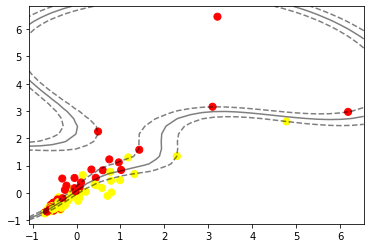

In [28]:
best_gaussian_model = SVC(**rbfKernel_param)
best_gaussian_model.fit(X_train, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c =y_train, s=50, cmap='autumn')
plot_svc_decision_function(best_gaussian_model);

##### Here we can visualize the decision boundary for the best Polynomial Model according to the grid search

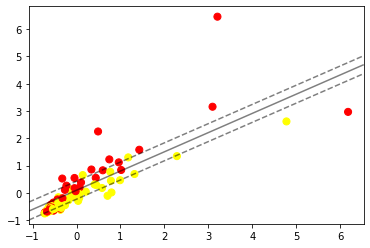

In [29]:
best_polynomial_model = SVC(**polyKernel_param)
best_polynomial_model.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c =y_train, s=50, cmap='autumn')
plot_svc_decision_function(best_polynomial_model);

Overfitting and Underfitting
=========
Analyzing Hig Variance -low Bias(overfitting)  and High Bias/Low variance(underfitting)
In the end one has to find a trade of between the Regularization Parameter C and the parameter Gamma

Low Gamma corresponds to underfitting, High Gamma to overfitting

A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplan

###### Gaussian Kernel - Overfitting 

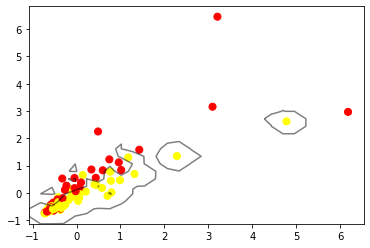

In [30]:
gauss_param = {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 50, 'kernel': 'rbf'}
gauss_model = SVC(**gauss_param)
gauss_model.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c =y_train, s=50, cmap='autumn')
plot_svc_decision_function(gauss_model);

##### Gaussian Kernel - Underfitting

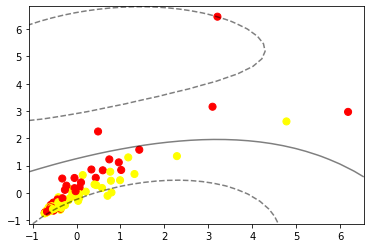

In [31]:
gauss_param = {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.05, 'kernel': 'rbf'}
gauss_model = SVC(**gauss_param)
gauss_model.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c =y_train, s=50, cmap='autumn')
plot_svc_decision_function(gauss_model);

###### Polynomial Kernel - Overfitting

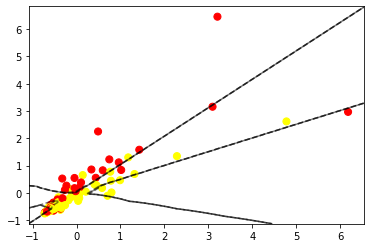

In [32]:
polyKernel_param = {'C': 10, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 100, 'kernel': 'poly'}
polynomial_model = SVC(**polyKernel_param)
polynomial_model.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c =y_train, s=50, cmap='autumn')
plot_svc_decision_function(polynomial_model);

#### Polynomial Kernel - Underfitting

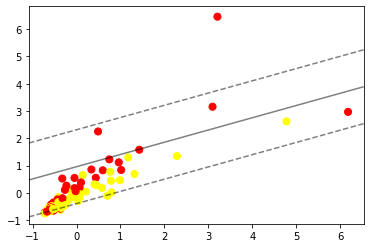

In [33]:
polyKernel_param = {'C': 0.1, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 1, 'kernel': 'poly'}
polynomial_model = SVC(**polyKernel_param)
polynomial_model.fit(X_train, y_train)

plt.scatter(X_train[:, 0], X_train[:, 1], c =y_train, s=50, cmap='autumn')
plot_svc_decision_function(polynomial_model);

Training of different SVM with the whole feature Space
=============

Here I used the library pyAudioAnalysis Library in order to extract and train an SVM with Gaussian and linear Kernel. 
All the features are used and again the best classifier from a set of parameter is choosen and the resulting classifier ist stored as ARFF file for later classifications.

### Linear Kernel

In [70]:

from pyAudioAnalysis import audioTrainTest as aT
aT.extract_features_and_train(["./data_c_s/Coughing","./data_c_s/Sneezing"], 0.2, 0.2, aT.shortTermWindow, aT.shortTermStep, "svm", "svm_linear", False, train_percentage=0.80)

Analyzing file 1 of 29: ./data_c_s/Coughing\108017__erocshadow__cough.wav
Analyzing file 2 of 29: ./data_c_s/Coughing\146873__tgfcoder__male-sick-cough.wav
Analyzing file 3 of 29: ./data_c_s/Coughing\152995__nmb910__cough.wav
Analyzing file 4 of 29: ./data_c_s/Coughing\155650__poorenglishjuggler__cough.wav
Analyzing file 5 of 29: ./data_c_s/Coughing\157296__husky70__coughing-cough.wav
Analyzing file 6 of 29: ./data_c_s/Coughing\16580__jascha__husten-tief-mit-nachhall.wav
Analyzing file 7 of 29: ./data_c_s/Coughing\17167__lg__cough01.wav
Analyzing file 8 of 29: ./data_c_s/Coughing\19023__danglada__cough.wav
Analyzing file 9 of 29: ./data_c_s/Coughing\204604__pikachu09__cough.wav
Analyzing file 10 of 29: ./data_c_s/Coughing\208761__harris85__cough.wav
Analyzing file 11 of 29: ./data_c_s/Coughing\21314__zippi1__sound-cough2.wav
Analyzing file 12 of 29: ./data_c_s/Coughing\218306__splicesound__woman-female-coughing-sniffing.wav
Analyzing file 13 of 29: ./data_c_s/Coughing\251489__aderumoro

Param = 0.00100 - classifier Evaluation Experiment 30 of 100
Param = 0.00100 - classifier Evaluation Experiment 31 of 100
Param = 0.00100 - classifier Evaluation Experiment 32 of 100
Param = 0.00100 - classifier Evaluation Experiment 33 of 100
Param = 0.00100 - classifier Evaluation Experiment 34 of 100
Param = 0.00100 - classifier Evaluation Experiment 35 of 100
Param = 0.00100 - classifier Evaluation Experiment 36 of 100
Param = 0.00100 - classifier Evaluation Experiment 37 of 100
Param = 0.00100 - classifier Evaluation Experiment 38 of 100
Param = 0.00100 - classifier Evaluation Experiment 39 of 100
Param = 0.00100 - classifier Evaluation Experiment 40 of 100
Param = 0.00100 - classifier Evaluation Experiment 41 of 100
Param = 0.00100 - classifier Evaluation Experiment 42 of 100
Param = 0.00100 - classifier Evaluation Experiment 43 of 100
Param = 0.00100 - classifier Evaluation Experiment 44 of 100
Param = 0.00100 - classifier Evaluation Experiment 45 of 100
Param = 0.00100 - classi

Param = 0.01000 - classifier Evaluation Experiment 77 of 100
Param = 0.01000 - classifier Evaluation Experiment 78 of 100
Param = 0.01000 - classifier Evaluation Experiment 79 of 100
Param = 0.01000 - classifier Evaluation Experiment 80 of 100
Param = 0.01000 - classifier Evaluation Experiment 81 of 100
Param = 0.01000 - classifier Evaluation Experiment 82 of 100
Param = 0.01000 - classifier Evaluation Experiment 83 of 100
Param = 0.01000 - classifier Evaluation Experiment 84 of 100
Param = 0.01000 - classifier Evaluation Experiment 85 of 100
Param = 0.01000 - classifier Evaluation Experiment 86 of 100
Param = 0.01000 - classifier Evaluation Experiment 87 of 100
Param = 0.01000 - classifier Evaluation Experiment 88 of 100
Param = 0.01000 - classifier Evaluation Experiment 89 of 100
Param = 0.01000 - classifier Evaluation Experiment 90 of 100
Param = 0.01000 - classifier Evaluation Experiment 91 of 100
Param = 0.01000 - classifier Evaluation Experiment 92 of 100
Param = 0.01000 - classi

Param = 1.00000 - classifier Evaluation Experiment 31 of 100
Param = 1.00000 - classifier Evaluation Experiment 32 of 100
Param = 1.00000 - classifier Evaluation Experiment 33 of 100
Param = 1.00000 - classifier Evaluation Experiment 34 of 100
Param = 1.00000 - classifier Evaluation Experiment 35 of 100
Param = 1.00000 - classifier Evaluation Experiment 36 of 100
Param = 1.00000 - classifier Evaluation Experiment 37 of 100
Param = 1.00000 - classifier Evaluation Experiment 38 of 100
Param = 1.00000 - classifier Evaluation Experiment 39 of 100
Param = 1.00000 - classifier Evaluation Experiment 40 of 100
Param = 1.00000 - classifier Evaluation Experiment 41 of 100
Param = 1.00000 - classifier Evaluation Experiment 42 of 100
Param = 1.00000 - classifier Evaluation Experiment 43 of 100
Param = 1.00000 - classifier Evaluation Experiment 44 of 100
Param = 1.00000 - classifier Evaluation Experiment 45 of 100
Param = 1.00000 - classifier Evaluation Experiment 46 of 100
Param = 1.00000 - classi

Param = 5.00000 - classifier Evaluation Experiment 84 of 100
Param = 5.00000 - classifier Evaluation Experiment 85 of 100
Param = 5.00000 - classifier Evaluation Experiment 86 of 100
Param = 5.00000 - classifier Evaluation Experiment 87 of 100
Param = 5.00000 - classifier Evaluation Experiment 88 of 100
Param = 5.00000 - classifier Evaluation Experiment 89 of 100
Param = 5.00000 - classifier Evaluation Experiment 90 of 100
Param = 5.00000 - classifier Evaluation Experiment 91 of 100
Param = 5.00000 - classifier Evaluation Experiment 92 of 100
Param = 5.00000 - classifier Evaluation Experiment 93 of 100
Param = 5.00000 - classifier Evaluation Experiment 94 of 100
Param = 5.00000 - classifier Evaluation Experiment 95 of 100
Param = 5.00000 - classifier Evaluation Experiment 96 of 100
Param = 5.00000 - classifier Evaluation Experiment 97 of 100
Param = 5.00000 - classifier Evaluation Experiment 98 of 100
Param = 5.00000 - classifier Evaluation Experiment 99 of 100
Param = 5.00000 - classi

Param = 20.00000 - classifier Evaluation Experiment 34 of 100
Param = 20.00000 - classifier Evaluation Experiment 35 of 100
Param = 20.00000 - classifier Evaluation Experiment 36 of 100
Param = 20.00000 - classifier Evaluation Experiment 37 of 100
Param = 20.00000 - classifier Evaluation Experiment 38 of 100
Param = 20.00000 - classifier Evaluation Experiment 39 of 100
Param = 20.00000 - classifier Evaluation Experiment 40 of 100
Param = 20.00000 - classifier Evaluation Experiment 41 of 100
Param = 20.00000 - classifier Evaluation Experiment 42 of 100
Param = 20.00000 - classifier Evaluation Experiment 43 of 100
Param = 20.00000 - classifier Evaluation Experiment 44 of 100
Param = 20.00000 - classifier Evaluation Experiment 45 of 100
Param = 20.00000 - classifier Evaluation Experiment 46 of 100
Param = 20.00000 - classifier Evaluation Experiment 47 of 100
Param = 20.00000 - classifier Evaluation Experiment 48 of 100
Param = 20.00000 - classifier Evaluation Experiment 49 of 100
Param = 

### Gaussian Kernel

In [71]:
aT.extract_features_and_train(["./data_c_s/Coughing","./data_c_s/Sneezing"], 0.2, 0.2, aT.shortTermWindow, aT.shortTermStep, "svm_rbf", "svm_rbf", False, train_percentage=0.80)

Analyzing file 1 of 29: ./data_c_s/Coughing\108017__erocshadow__cough.wav
Analyzing file 2 of 29: ./data_c_s/Coughing\146873__tgfcoder__male-sick-cough.wav
Analyzing file 3 of 29: ./data_c_s/Coughing\152995__nmb910__cough.wav
Analyzing file 4 of 29: ./data_c_s/Coughing\155650__poorenglishjuggler__cough.wav
Analyzing file 5 of 29: ./data_c_s/Coughing\157296__husky70__coughing-cough.wav
Analyzing file 6 of 29: ./data_c_s/Coughing\16580__jascha__husten-tief-mit-nachhall.wav
Analyzing file 7 of 29: ./data_c_s/Coughing\17167__lg__cough01.wav
Analyzing file 8 of 29: ./data_c_s/Coughing\19023__danglada__cough.wav
Analyzing file 9 of 29: ./data_c_s/Coughing\204604__pikachu09__cough.wav
Analyzing file 10 of 29: ./data_c_s/Coughing\208761__harris85__cough.wav
Analyzing file 11 of 29: ./data_c_s/Coughing\21314__zippi1__sound-cough2.wav
Analyzing file 12 of 29: ./data_c_s/Coughing\218306__splicesound__woman-female-coughing-sniffing.wav
Analyzing file 13 of 29: ./data_c_s/Coughing\251489__aderumoro

Param = 0.00100 - classifier Evaluation Experiment 49 of 100
Param = 0.00100 - classifier Evaluation Experiment 50 of 100
Param = 0.00100 - classifier Evaluation Experiment 51 of 100
Param = 0.00100 - classifier Evaluation Experiment 52 of 100
Param = 0.00100 - classifier Evaluation Experiment 53 of 100
Param = 0.00100 - classifier Evaluation Experiment 54 of 100
Param = 0.00100 - classifier Evaluation Experiment 55 of 100
Param = 0.00100 - classifier Evaluation Experiment 56 of 100
Param = 0.00100 - classifier Evaluation Experiment 57 of 100
Param = 0.00100 - classifier Evaluation Experiment 58 of 100
Param = 0.00100 - classifier Evaluation Experiment 59 of 100
Param = 0.00100 - classifier Evaluation Experiment 60 of 100
Param = 0.00100 - classifier Evaluation Experiment 61 of 100
Param = 0.00100 - classifier Evaluation Experiment 62 of 100
Param = 0.00100 - classifier Evaluation Experiment 63 of 100
Param = 0.00100 - classifier Evaluation Experiment 64 of 100
Param = 0.00100 - classi

Param = 0.01000 - classifier Evaluation Experiment 95 of 100
Param = 0.01000 - classifier Evaluation Experiment 96 of 100
Param = 0.01000 - classifier Evaluation Experiment 97 of 100
Param = 0.01000 - classifier Evaluation Experiment 98 of 100
Param = 0.01000 - classifier Evaluation Experiment 99 of 100
Param = 0.01000 - classifier Evaluation Experiment 100 of 100
Param = 0.50000 - classifier Evaluation Experiment 1 of 100
Param = 0.50000 - classifier Evaluation Experiment 2 of 100
Param = 0.50000 - classifier Evaluation Experiment 3 of 100
Param = 0.50000 - classifier Evaluation Experiment 4 of 100
Param = 0.50000 - classifier Evaluation Experiment 5 of 100
Param = 0.50000 - classifier Evaluation Experiment 6 of 100
Param = 0.50000 - classifier Evaluation Experiment 7 of 100
Param = 0.50000 - classifier Evaluation Experiment 8 of 100
Param = 0.50000 - classifier Evaluation Experiment 9 of 100
Param = 0.50000 - classifier Evaluation Experiment 10 of 100
Param = 0.50000 - classifier Eva

Param = 1.00000 - classifier Evaluation Experiment 41 of 100
Param = 1.00000 - classifier Evaluation Experiment 42 of 100
Param = 1.00000 - classifier Evaluation Experiment 43 of 100
Param = 1.00000 - classifier Evaluation Experiment 44 of 100
Param = 1.00000 - classifier Evaluation Experiment 45 of 100
Param = 1.00000 - classifier Evaluation Experiment 46 of 100
Param = 1.00000 - classifier Evaluation Experiment 47 of 100
Param = 1.00000 - classifier Evaluation Experiment 48 of 100
Param = 1.00000 - classifier Evaluation Experiment 49 of 100
Param = 1.00000 - classifier Evaluation Experiment 50 of 100
Param = 1.00000 - classifier Evaluation Experiment 51 of 100
Param = 1.00000 - classifier Evaluation Experiment 52 of 100
Param = 1.00000 - classifier Evaluation Experiment 53 of 100
Param = 1.00000 - classifier Evaluation Experiment 54 of 100
Param = 1.00000 - classifier Evaluation Experiment 55 of 100
Param = 1.00000 - classifier Evaluation Experiment 56 of 100
Param = 1.00000 - classi

Param = 5.00000 - classifier Evaluation Experiment 78 of 100
Param = 5.00000 - classifier Evaluation Experiment 79 of 100
Param = 5.00000 - classifier Evaluation Experiment 80 of 100
Param = 5.00000 - classifier Evaluation Experiment 81 of 100
Param = 5.00000 - classifier Evaluation Experiment 82 of 100
Param = 5.00000 - classifier Evaluation Experiment 83 of 100
Param = 5.00000 - classifier Evaluation Experiment 84 of 100
Param = 5.00000 - classifier Evaluation Experiment 85 of 100
Param = 5.00000 - classifier Evaluation Experiment 86 of 100
Param = 5.00000 - classifier Evaluation Experiment 87 of 100
Param = 5.00000 - classifier Evaluation Experiment 88 of 100
Param = 5.00000 - classifier Evaluation Experiment 89 of 100
Param = 5.00000 - classifier Evaluation Experiment 90 of 100
Param = 5.00000 - classifier Evaluation Experiment 91 of 100
Param = 5.00000 - classifier Evaluation Experiment 92 of 100
Param = 5.00000 - classifier Evaluation Experiment 93 of 100
Param = 5.00000 - classi

Param = 20.00000 - classifier Evaluation Experiment 13 of 100
Param = 20.00000 - classifier Evaluation Experiment 14 of 100
Param = 20.00000 - classifier Evaluation Experiment 15 of 100
Param = 20.00000 - classifier Evaluation Experiment 16 of 100
Param = 20.00000 - classifier Evaluation Experiment 17 of 100
Param = 20.00000 - classifier Evaluation Experiment 18 of 100
Param = 20.00000 - classifier Evaluation Experiment 19 of 100
Param = 20.00000 - classifier Evaluation Experiment 20 of 100
Param = 20.00000 - classifier Evaluation Experiment 21 of 100
Param = 20.00000 - classifier Evaluation Experiment 22 of 100
Param = 20.00000 - classifier Evaluation Experiment 23 of 100
Param = 20.00000 - classifier Evaluation Experiment 24 of 100
Param = 20.00000 - classifier Evaluation Experiment 25 of 100
Param = 20.00000 - classifier Evaluation Experiment 26 of 100
Param = 20.00000 - classifier Evaluation Experiment 27 of 100
Param = 20.00000 - classifier Evaluation Experiment 28 of 100
Param = 